In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [4]:
dataset = datasets.ImageFolder("./dataset", transform=train_transform)

# split 70/15/15
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(SEED))

val_ds.dataset.transform = val_transform
test_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

class_names = dataset.classes
print("Classes:", dataset.classes)

Classes: ['Hawar', 'Karat', 'Sehat']


In [5]:
def build_model(model_name, num_classes, fine_tune=False):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)

        # Freeze / Fine-tune
        if not fine_tune:
            for param in model.parameters():
                param.requires_grad = False
        else:
            for name, param in model.named_parameters():
                if "layer4" not in name:  # freeze all except last block
                    param.requires_grad = False

        # Replace FC
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    else:
        raise ValueError("Model not supported")

    return model.to(device)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5, patience=4):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validate
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
              f"- Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{type(model).__name__}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [7]:
def evaluate_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {type(model).__name__}")
    plt.show()


===== Training RESNET50 =====


d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\Miniconda\envs\dl_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5 - Train Loss: 0.1635 Train Acc: 0.9377 - Val Loss: 0.0714 Val Acc: 0.9745
Epoch 2/5 - Train Loss: 0.0616 Train Acc: 0.9774 - Val Loss: 0.0954 Val Acc: 0.9711
Epoch 3/5 - Train Loss: 0.0513 Train Acc: 0.9865 - Val Loss: 0.0722 Val Acc: 0.9830
Epoch 4/5 - Train Loss: 0.0253 Train Acc: 0.9924 - Val Loss: 0.0428 Val Acc: 0.9881
Epoch 5/5 - Train Loss: 0.0107 Train Acc: 0.9967 - Val Loss: 0.1064 Val Acc: 0.9830
Training complete.


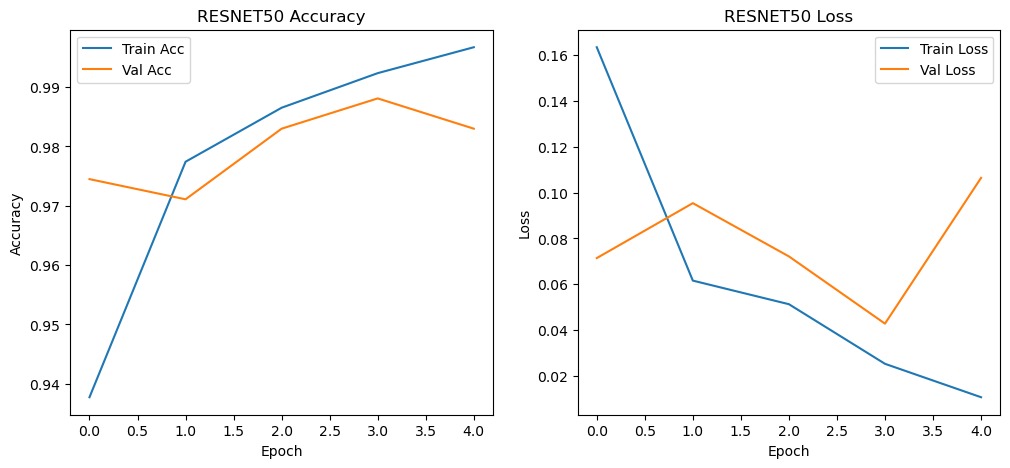

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20588\559994869.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Classification Report:
              precision    recall  f1-score   support

       Hawar       0.98      0.98      0.98       179
       Karat       0.99      0.98      0.98       214
       Sehat       1.00      1.00      1.00       197

    accuracy                           0.99       590
   macro avg       0.99      0.99      0.99       590
weighted avg       0.99      0.99      0.99       590



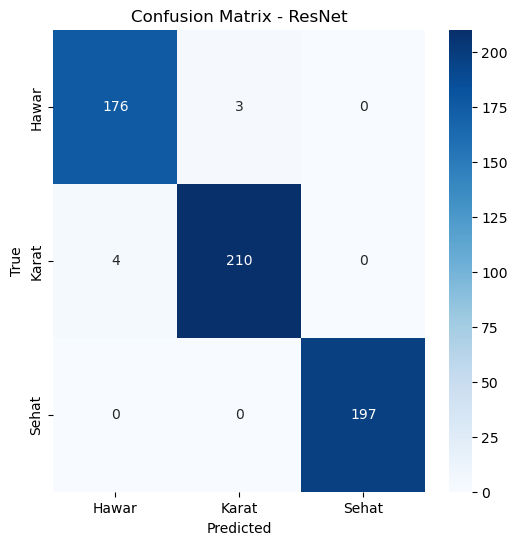

In [8]:
for arch in ["resnet50"]:
    print(f"\n===== Training {arch.upper()} =====")
    model = build_model(arch, num_classes=len(class_names), fine_tune=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=5, patience=4)

    # Plot accuracy & loss curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title(f'{arch.upper()} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'{arch.upper()} Loss')
    plt.legend()
    plt.show()

    evaluate_model(model, f"best_{type(model).__name__}.pth")

In [9]:
def visualize_gradcam(model, test_loader, target_layer, device, num_images=5):
    model.eval()
    images_shown = 0

    cam = GradCAM(model=model, target_layers=[target_layer])

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        for i in range(images.size(0)):
            if images_shown >= num_images:
                return
            input_tensor = images[i].unsqueeze(0)
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)
            grayscale_cam = grayscale_cam[0, :]
            
            img_np = images[i].permute(1,2,0).cpu().numpy()
            img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
            img_np = np.clip(img_np, 0, 1)

            cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
            
            plt.figure(figsize=(4,4))
            plt.imshow(cam_image)
            plt.title(f"True: {labels[i].item()}")
            plt.axis('off')
            plt.show()
            images_shown += 1


===== Grad-CAM for RESNET50 =====


d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20588\2676559573.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURIT

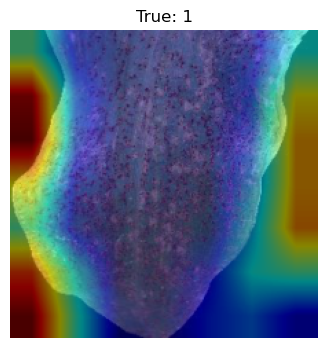

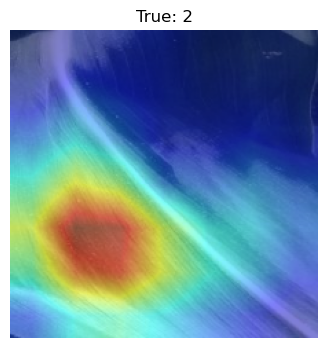

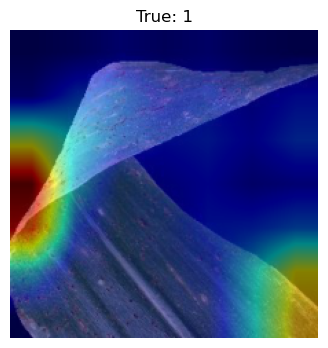

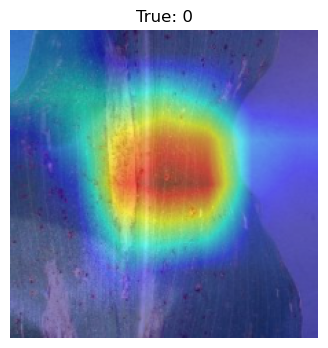

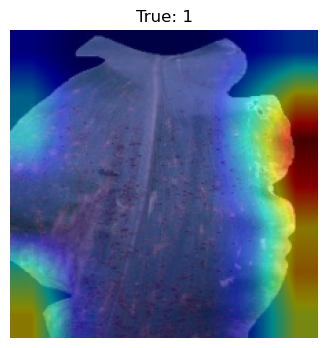

In [10]:
for arch in ["resnet50"]:
    print(f"\n===== Grad-CAM for {arch.upper()} =====")
    model = build_model(arch, num_classes=len(class_names), fine_tune=True)
    model.load_state_dict(torch.load(f"best_{type(model).__name__}.pth"))
    model.to(device)

    if arch == "resnet50":
        target_layer = model.layer4[-1].conv3
    else:  # efficientnet_b0
        target_layer = model.features[-1]

    visualize_gradcam(model, test_loader, target_layer, device, num_images=5)